<a href="https://colab.research.google.com/github/alex-bolshunov/Clustering-ML/blob/main/clustering_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from itertools import chain

In [245]:
N_SAMPLES = 500
N_FEATURES = 2
P_RANDOM_POINTS = 0.05
RANDOM_STATE = 42
COLUMNS = ["Feature 1", "Feature 2", "Target"]
NAMES = ["Globular", "Moons", "Circles"]

In [246]:
def create_df(X, y):
  #accept numpy arrays return one dataframe
  X = pd.DataFrame(X, columns = COLUMNS[:N_FEATURES])
  y = pd.DataFrame(y, columns = COLUMNS[N_FEATURES:])

  return X.join(y)

In [247]:
def plot_dfs(dfs, h = 4.5, margin = 0.2, title = "Types of clusters", alpha = 0.4, **kwargs):
  #define vars
  n = len(dfs)
  margin += 1
  centroids = kwargs.get("centroids", False)
  labels = kwargs.get("labels", False)
  is_clustered = labels
  is_kmeans = centroids

  if is_clustered:
    plot_params = {"alpha": alpha, "zorder":5, "edgecolors":"k", "cmap": "plasma"}
    centroids_params = {"s":200, "c":'red', "marker": "X", "label":"Centroids", "zorder":10}
  else:
    plot_params = { "alpha": alpha, "zorder":5, "edgecolors": "k"}

  grid_params = { "alpha": 0.3,"zorder":1}

  fig, ax = plt.subplots(1, n, figsize = (n * h + n, h))

  for i, df in enumerate(dfs):
    #get lim for each df
    min_x_lim = df[COLUMNS[0]].min() * margin
    max_x_lim = df[COLUMNS[0]].max() * margin
    min_y_lim = df[COLUMNS[1]].min() * margin
    max_y_lim = df[COLUMNS[1]].max() * margin

    #plot each df
    if is_clustered:
      ax[i].scatter(df[COLUMNS[0]],df[COLUMNS[1]], c=labels[i], **plot_params)
      if is_kmeans:
        ax[i].scatter(centroids[i][:, 0],centroids[i][:, 1],**centroids_params)
        ax[i].legend()
    else:
      ax[i].scatter(df[COLUMNS[0]],df[COLUMNS[1]], **plot_params)

    ax[i].grid(**grid_params)
    ax[i].set_title(NAMES[i])
    ax[i].set_xlim((min_x_lim, max_x_lim))
    ax[i].set_ylim((min_y_lim, max_y_lim))
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")

  plt.suptitle(title)

  plt.show();

In [248]:
#add random_points within range
def add_random_points(df, p_points):
  n_points = int(df.shape[0] * p_points)

  #get min and max value for each feature
  min_features_values = df.loc[:, COLUMNS[:N_FEATURES]].min().tolist()
  max_features_values = df.loc[:, COLUMNS[:N_FEATURES]].max().tolist()

  points = []

  z = zip(min_features_values, max_features_values)

  #generate random n_points random values for each feature
  for min_val, max_val in z:
    points.append(np.random.uniform(min_val, max_val, size=n_points))

  #create dataframe
  new_points_df = pd.DataFrame(zip(*points), columns = COLUMNS[:N_FEATURES])
  points_class = pd.DataFrame(
      np.random.choice(df[COLUMNS[-1]].unique(), size = n_points),
      columns=COLUMNS[N_FEATURES:]
      )

  new_points_df = pd.merge(new_points_df, points_class, left_index=True, right_index=True)

  return pd.concat([df, new_points_df], ignore_index= True)

In [249]:
#add random points using standard deviation
def add_random_points_std(df, p_points, s = None):
  n_points = int(df.shape[0] * p_points)

  if s is None: s = df.loc[:, COLUMNS[:N_FEATURES]].std().min() #select min std for both features

  points = np.random.normal(loc=0, scale=s, size=(n_points, N_FEATURES))
  points_class = np.random.choice(df[COLUMNS[-1]].unique(), size = n_points)

  df_noise = create_df(points, points_class)

  return pd.concat([df, df_noise], ignore_index=True)

In [250]:
def plot_single_metric(xlabels, heights, title = "", figsize = (8, 4), alpha = 0.7, color = "#ff3333", edgecolor = "black"):
  fig, ax = plt.subplots(figsize = figsize)
  ax.bar(xlabels, heights, alpha = alpha, color = color, edgecolor = edgecolor, zorder = 5)
  ax.axhline(y=0, color='black', linewidth=1.5)
  ax.set_xticks(x)
  ax.set_xticklabels(x, rotation = 45)
  ax.set_ylabel('Value')
  ax.set_xlabel("Model Name")
  ax.set_title(title)
  plt.grid(alpha = 0.3, zorder = 1)
  plt.show()

In [251]:
class Evaluation():
  def __init__(self):
    self.metrics = {}
    self.sil = "silhouette"
    self.db = "davies_bouldin"
    self.ch = "calinski_harabasz"

  def _calc_scores(self, df, labels):
    return {
        self.sil: silhouette_score(df, labels),
        self.db: davies_bouldin_score(df, labels),
        self.ch: calinski_harabasz_score(df, labels)
    }

  def _round(self, n, p = 5):
    return round(n, p)

  def get_model_names(self):
    return list(self.metrics.keys())

  def _to_dict_by_score_name(self):
    flag = False
    score_values = []
    score_names = []
    models = self.get_model_names()

    for model in models:
      if not flag:
        score_names = list(self.metrics[model].keys())
        flag = True
      score_values.append(list(self.metrics[model].values()))

    score_values = [tp_scores for tp_scores in zip(*score_values)]

    return {score_names[i]:score for i, score in enumerate(score_values)}

  def evaluate_model(self, name, df, labels):
    self.metrics[name] = self._calc_scores(df, labels)

  def get_single_type_metric(self, df_type, metric_name):
    model_metrics_list = []

    for model_name, metrics in self.metrics.items():
      if df_type in model_name.lower():
        model_metrics_list.append((model_name, metrics.get(metric_name, None)))

    return model_metrics_list

  def get_max_metric(self, df_type, metric):
    metrics = self.get_single_type_metric(df_type, metric)
    model_name = ""
    max_value = -np.inf
    metric_value = -np.inf

    for name, local_metric in metrics:
      if max_value < np.abs(local_metric):
        max_value = np.abs(local_metric)
        metric_value = local_metric
        model_name = name

    return model_name, metric_value

  def get_min_metric(self, df_type, metric):
    metrics = self.get_single_type_metric(df_type, metric)
    model_name = ""
    max_value = np.inf
    metric_value = np.inf

    for name, local_metric in metrics:
      if max_value > np.abs(local_metric):
        max_value = np.abs(local_metric)
        metric_value = local_metric
        model_name = name

    return model_name, metric_value

  def print_metrics(self):
    for val, key in self.metrics.items():
      print(f"Name: {val}")
      print(f"{self.sil}: {self._round(key[self.sil])}")
      print(f"{self.db}: {self._round(key[self.db])}")
      print(f"{self.ch}: {self._round(key[self.ch])}\n")

  def plot_models_score(self, name, title = "Score Metrics", alpha = 0.7, figsize = (6, 4), rotation = 0):
    dict_scores = self._to_dict_by_score_name()
    xlabels = self.get_model_names()
    scores = dict_scores.get(name, [])

    fig, ax = plt.subplots(figsize = figsize)
    ax.bar(xlabels, scores, alpha = alpha, edgecolor = "grey", zorder = 5)
    ax.axhline(y=0, color='black', linewidth=1.5)
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels, rotation = rotation)
    ax.set_ylabel('Value')
    ax.set_xlabel("Model Name")
    ax.set_title(title)
    plt.grid(alpha = 0.3, zorder = 1)
    plt.show()

# Modeling

## Dataset

In [252]:
#create synthetic dataframes
noise = 0.01

#globular
Xb, yb = make_blobs(n_samples=N_SAMPLES, n_features=N_FEATURES, random_state=RANDOM_STATE)
df_blobs = create_df(Xb, yb)

#moons
Xm, ym = make_moons(n_samples=N_SAMPLES, noise=noise, random_state=RANDOM_STATE)
df_moons = create_df(Xm,ym)

#circles
Xc, yc = make_circles(n_samples=N_SAMPLES, noise=noise, random_state=RANDOM_STATE)
df_circles = create_df(Xc,yc)

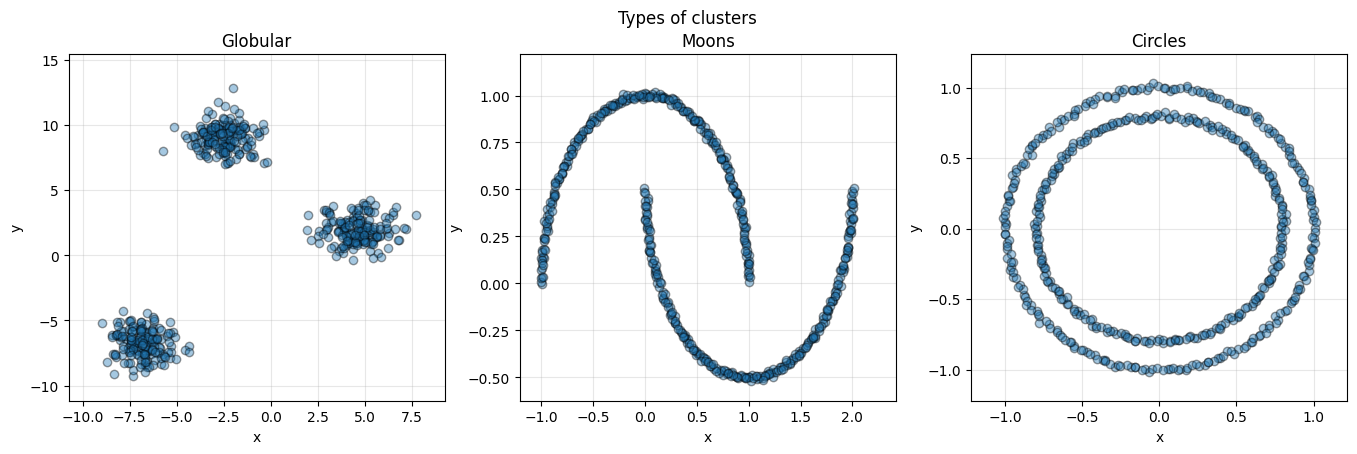

In [253]:
plot_dfs([df_blobs, df_moons, df_circles])

In [254]:
#add random points

#blobs
df_blobs = add_random_points(df_blobs, P_RANDOM_POINTS)

#moons
df_moons = add_random_points(df_moons, P_RANDOM_POINTS)

#circles
df_circles = add_random_points(df_circles, P_RANDOM_POINTS)

In [255]:
#get features for each dataset
X_blobs = df_blobs.loc[:, COLUMNS[:N_FEATURES]]
X_moons = df_moons.loc[:, COLUMNS[:N_FEATURES]]
X_circles = df_circles.loc[:, COLUMNS[:N_FEATURES]]

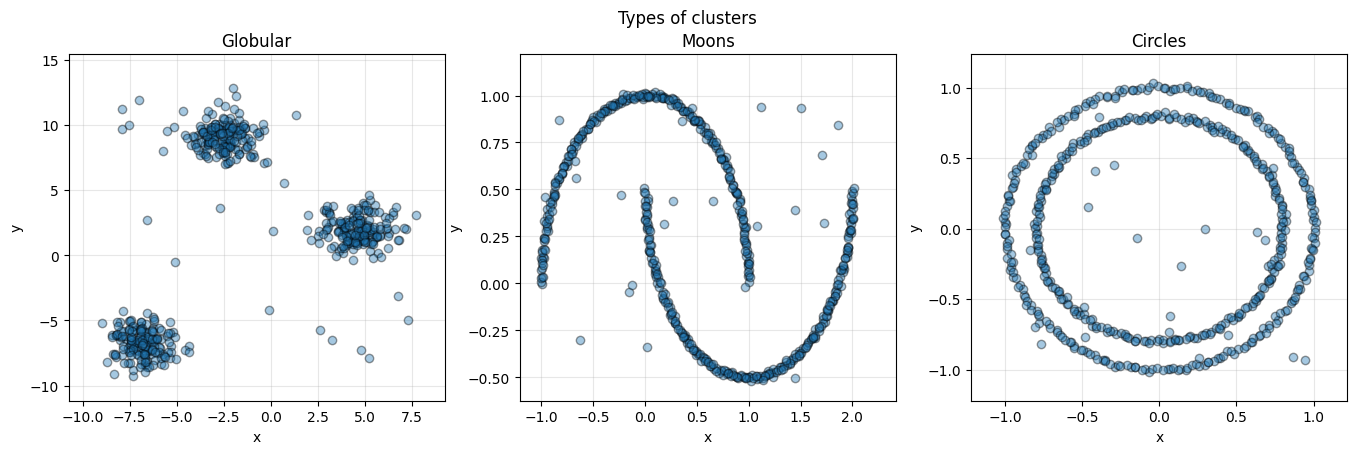

In [256]:
plot_dfs([X_blobs, X_moons, X_circles])

## K-means

In [257]:
kmeans_metrics = Evaluation()

In [258]:
#train model for each dataset

#blobs
k_means_blobs = KMeans(n_clusters=3, random_state=RANDOM_STATE)
k_means_blobs.fit(X_blobs)
labels_blobs = k_means_blobs.labels_
centroids_blobs = k_means_blobs.cluster_centers_

#moons
k_means_moons = KMeans(n_clusters=2, random_state=RANDOM_STATE)
k_means_moons.fit(X_moons)
labels_moons = k_means_moons.labels_
centroids_moons = k_means_moons.cluster_centers_

#circles
k_means_circles = KMeans(n_clusters=2, random_state=RANDOM_STATE)
k_means_circles.fit(X_circles)
labels_circles = k_means_circles.labels_
centroids_circles = k_means_circles.cluster_centers_

In [259]:
kmeans_metrics.evaluate_model("kmeans-blobs", X_blobs, labels_blobs)
kmeans_metrics.evaluate_model("kmeans-moons", X_moons, labels_moons)
kmeans_metrics.evaluate_model("kmeans-circles", X_circles, labels_circles)

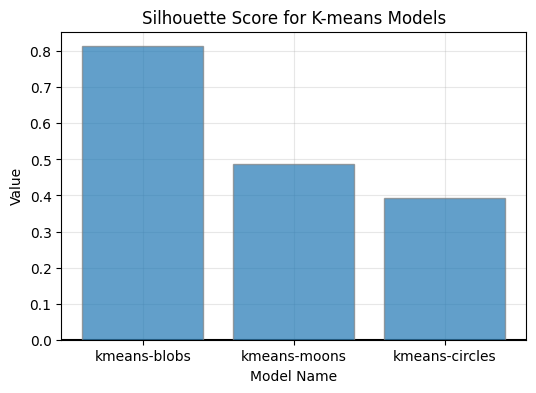

In [260]:
kmeans_metrics.plot_models_score("silhouette", title = "Silhouette Score for K-means Models", figsize = (6, 4))

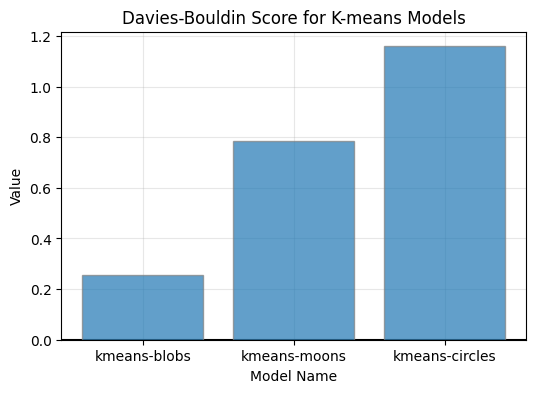

In [261]:
kmeans_metrics.plot_models_score("davies_bouldin", title = "Davies-Bouldin Score for K-means Models", figsize = (6, 4))

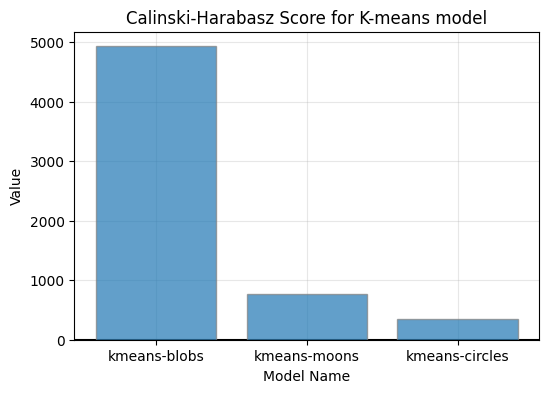

In [262]:
kmeans_metrics.plot_models_score("calinski_harabasz", title = "Calinski-Harabasz Score for K-means model", figsize = (6, 4))

In [263]:
kmeans_metrics.print_metrics()

Name: kmeans-blobs
silhouette: 0.81336
davies_bouldin: 0.25739
calinski_harabasz: 4931.75195

Name: kmeans-moons
silhouette: 0.48848
davies_bouldin: 0.78543
calinski_harabasz: 771.38088

Name: kmeans-circles
silhouette: 0.39373
davies_bouldin: 1.15857
calinski_harabasz: 340.83084



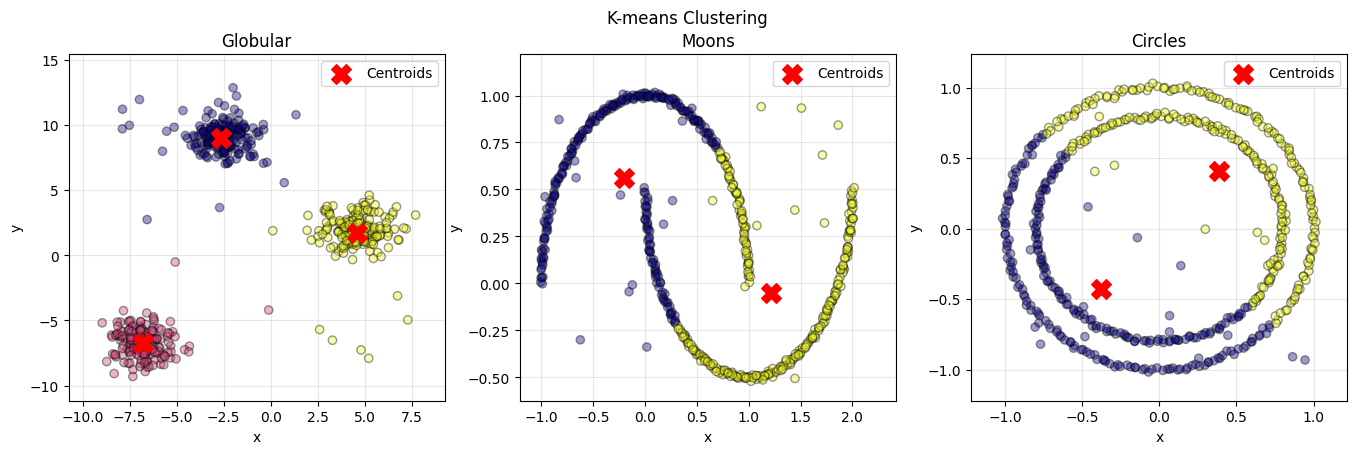

In [264]:
#plot kmeans
plot_dfs(
    dfs = [X_blobs, X_moons, X_circles],
    title = "K-means Clustering",
    centroids=[centroids_blobs, centroids_moons ,centroids_circles],
    labels=[labels_blobs, labels_moons, labels_circles])

## Hierarchical Clustering

In [265]:
hierarch_metrics = Evaluation()

In [266]:
#train single (min) links
linkage = "single"
n_clusters = 5

hbs = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
hbs.fit(X_blobs)
hbs_labels = hbs.labels_

hms = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
hms.fit(X_moons)
hms_labels = hms.labels_

hcs = AgglomerativeClustering(n_clusters = n_clusters,linkage = linkage)
hcs.fit(X_circles)
hcs_labels = hcs.labels_

In [267]:
hierarch_metrics.evaluate_model("single-blobs", df_blobs, hbs_labels)
hierarch_metrics.evaluate_model("single-moons", df_moons, hms_labels)
hierarch_metrics.evaluate_model("single-circles", df_circles, hcs_labels)

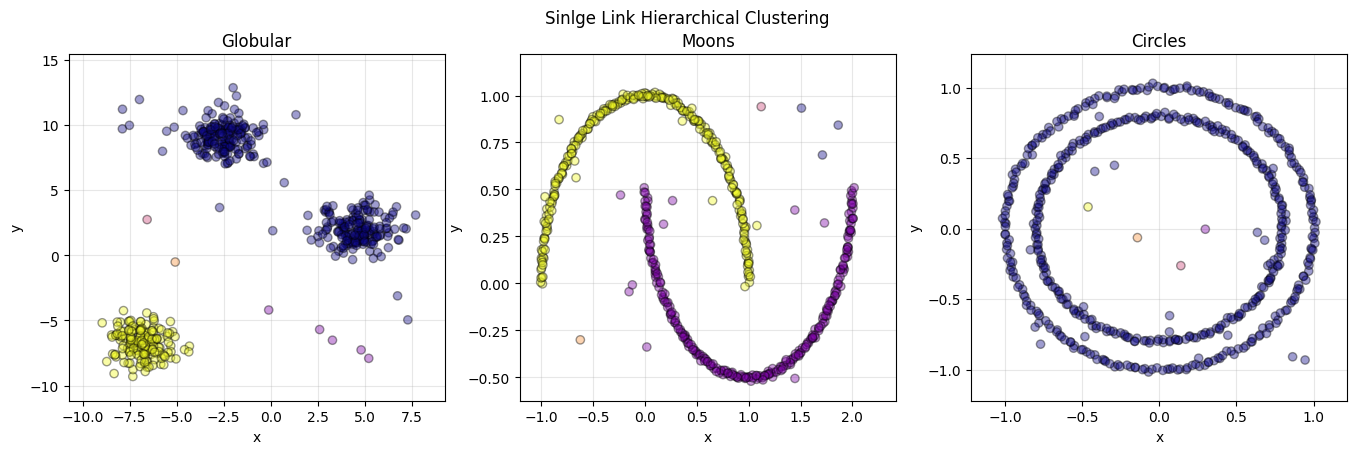

In [268]:
#plot
plot_dfs(
    dfs = [X_blobs, X_moons, X_circles],
    title = "Sinlge Link Hierarchical Clustering",
    labels=[hbs_labels, hms_labels, hcs_labels])

In [269]:
#train complete (max) links
linkage = "complete"
n_clusters = 3

hbc = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
hbc.fit(X_blobs)
hbc_labels = hbc.labels_

hmc = AgglomerativeClustering(linkage = linkage)
hmc.fit(X_moons)
hmc_labels = hmc.labels_

hcc = AgglomerativeClustering(linkage = linkage)
hcc.fit(X_circles)
hcc_labels = hcc.labels_

In [270]:
hierarch_metrics.evaluate_model("complete-blobs", df_blobs, hbc_labels)
hierarch_metrics.evaluate_model("complete-moons", df_moons, hmc_labels)
hierarch_metrics.evaluate_model("complete-circles", df_circles, hcc_labels)

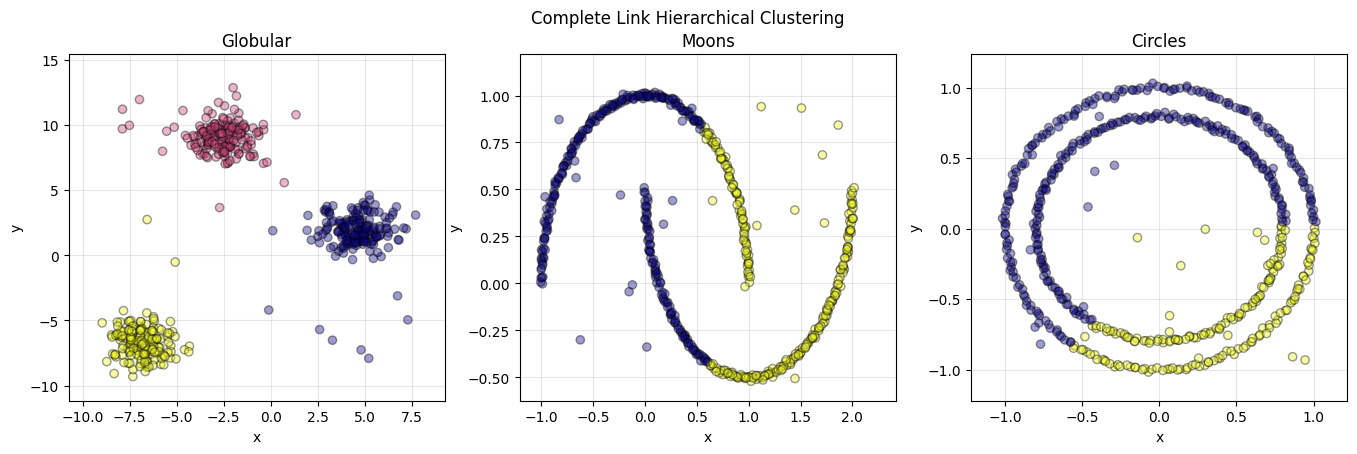

In [271]:
#plot
plot_dfs(
    dfs = [X_blobs, X_moons, X_circles],
    title = "Complete Link Hierarchical Clustering",
    labels=[hbc_labels, hmc_labels, hcc_labels])

In [272]:
#train average) links
linkage = "average"
n_clusters = 3

hba = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
hba.fit(X_blobs)
hba_labels = hba.labels_

hma = AgglomerativeClustering(linkage = linkage)
hma.fit(X_moons)
hma_labels = hma.labels_

hca = AgglomerativeClustering(linkage = linkage)
hca.fit(X_circles)
hca_labels = hca.labels_

In [273]:
hierarch_metrics.evaluate_model("average-blobs", df_blobs, hba_labels)
hierarch_metrics.evaluate_model("average-moons", df_moons, hma_labels)
hierarch_metrics.evaluate_model("average-circles", df_circles, hca_labels)

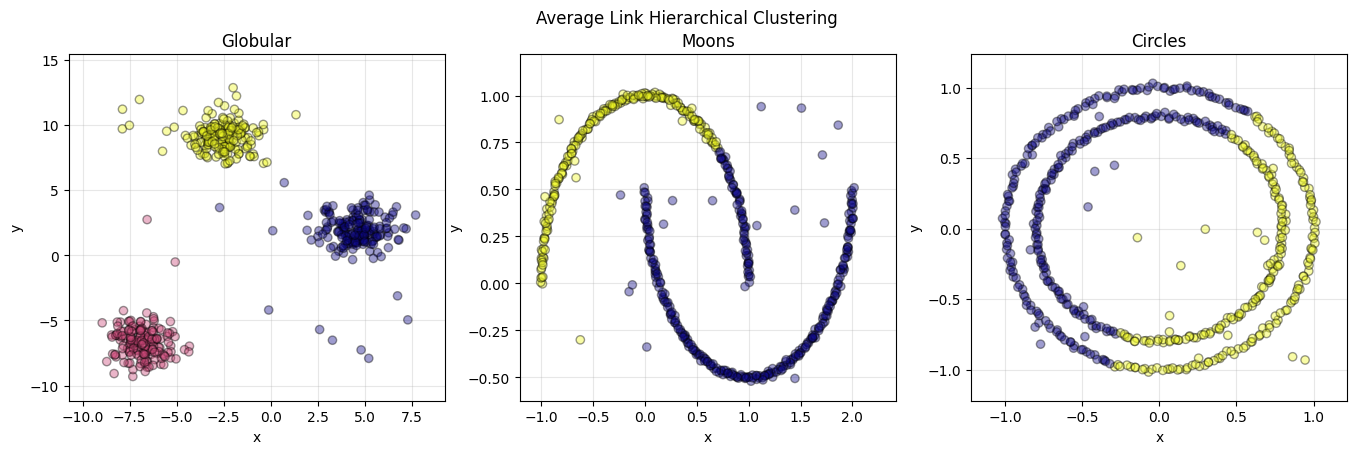

In [274]:
#plot
plot_dfs(
    dfs = [X_blobs, X_moons, X_circles],
    title = "Average Link Hierarchical Clustering",
    labels=[hba_labels, hma_labels, hca_labels])

In [275]:
#train (average) links
linkage = "ward"
n_clusters = 3

hbw = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
hbw.fit(X_blobs)
hbw_labels = hbw.labels_

hmw = AgglomerativeClustering(linkage = linkage)
hmw.fit(X_moons)
hmw_labels = hmw.labels_

hcw = AgglomerativeClustering(linkage = linkage)
hcw.fit(X_circles)
hcw_labels = hcw.labels_

In [276]:
hierarch_metrics.evaluate_model("ward-blobs", df_blobs, hba_labels)
hierarch_metrics.evaluate_model("ward-moons", df_moons, hma_labels)
hierarch_metrics.evaluate_model("ward-circles", df_circles, hca_labels)

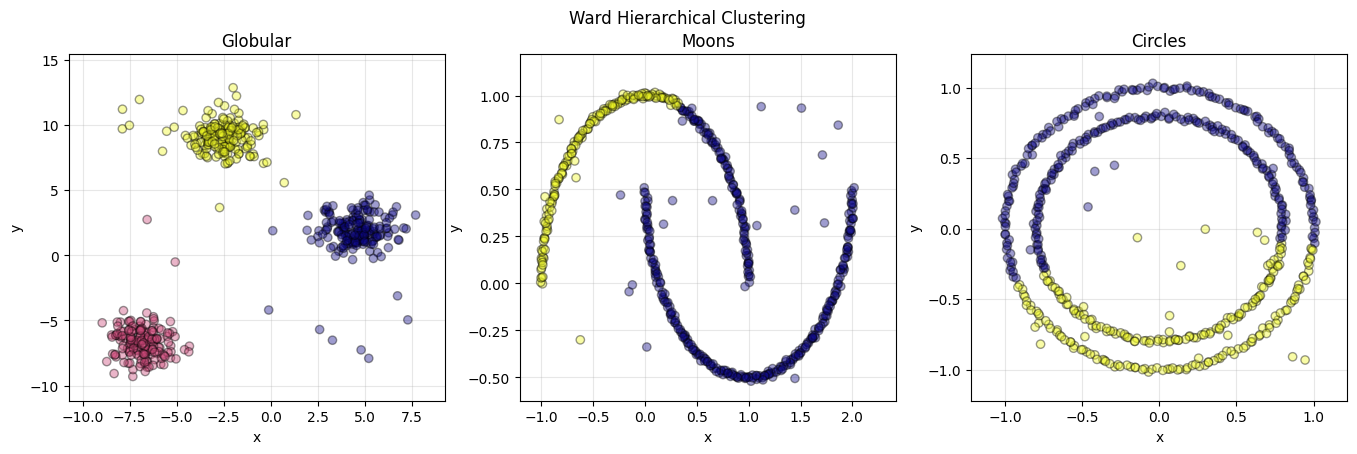

In [277]:
#plot
plot_dfs(
    dfs = [X_blobs, X_moons, X_circles],
    title = "Ward Hierarchical Clustering",
    labels=[hbw_labels, hmw_labels, hcw_labels])

In [278]:
hierarch_metrics.print_metrics()

Name: single-blobs
silhouette: 0.38957
davies_bouldin: 0.59026
calinski_harabasz: 304.5264

Name: single-moons
silhouette: 0.16635
davies_bouldin: 0.83163
calinski_harabasz: 131.01865

Name: single-circles
silhouette: -0.42828
davies_bouldin: 1.78961
calinski_harabasz: 0.33625

Name: complete-blobs
silhouette: 0.81191
davies_bouldin: 0.2588
calinski_harabasz: 4807.67275

Name: complete-moons
silhouette: 0.39671
davies_bouldin: 1.0293
calinski_harabasz: 467.01649

Name: complete-circles
silhouette: 0.26881
davies_bouldin: 1.49895
calinski_harabasz: 188.29001

Name: average-blobs
silhouette: 0.81006
davies_bouldin: 0.26129
calinski_harabasz: 4720.87597

Name: average-moons
silhouette: 0.45174
davies_bouldin: 0.8431
calinski_harabasz: 563.73608

Name: average-circles
silhouette: 0.30239
davies_bouldin: 1.46971
calinski_harabasz: 226.62141

Name: ward-blobs
silhouette: 0.81006
davies_bouldin: 0.26129
calinski_harabasz: 4720.87597

Name: ward-moons
silhouette: 0.45174
davies_bouldin: 0.8431

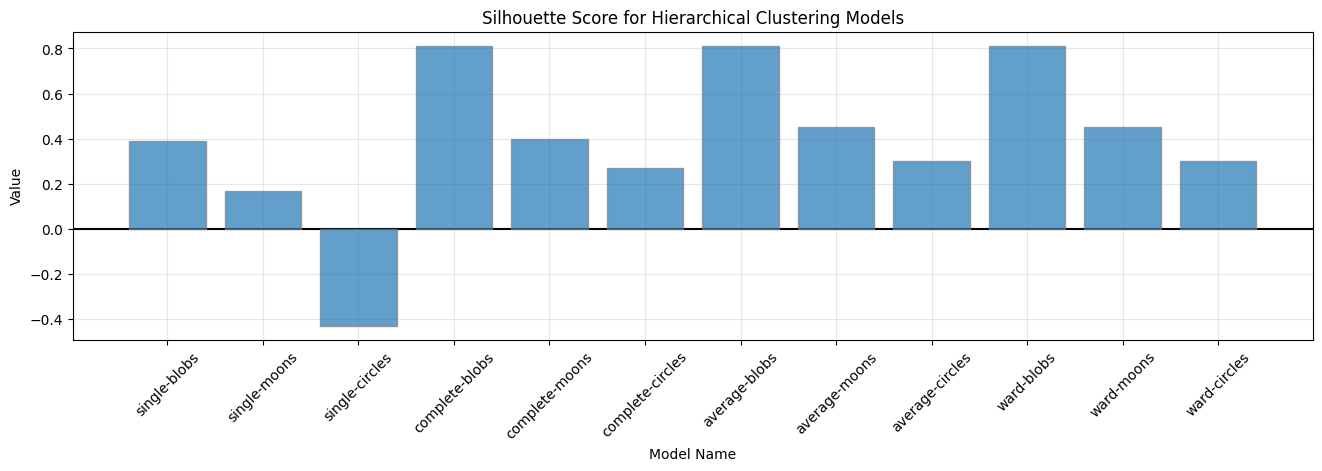

In [279]:
figsize = (16, 4)

hierarch_metrics.plot_models_score("silhouette", title = "Silhouette Score for Hierarchical Clustering Models", figsize = figsize, rotation = 45)

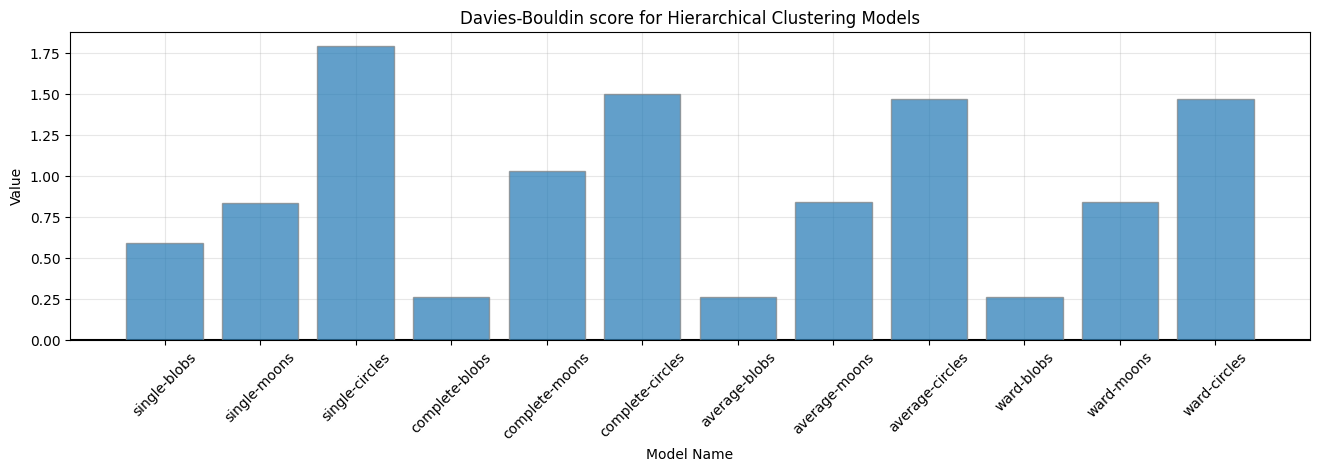

In [280]:
hierarch_metrics.plot_models_score("davies_bouldin", title = "Davies-Bouldin score for Hierarchical Clustering Models", figsize = figsize, rotation = 45)

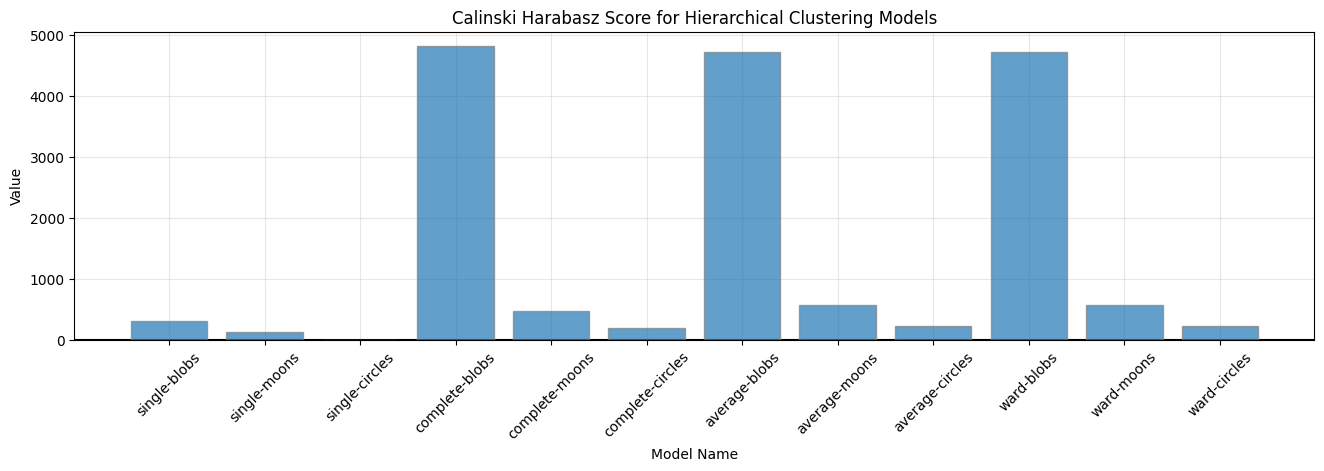

In [281]:
hierarch_metrics.plot_models_score("calinski_harabasz", title = "Calinski Harabasz Score for Hierarchical Clustering Models", figsize = figsize, rotation = 45)

## DBSCAN

In [282]:
dbscan_metrics = Evaluation()

In [283]:
#training dbscan, finetune parameters
eps_b = 1
min_samples_b = 8

dbscan_blobs = DBSCAN(eps=eps_b, min_samples=min_samples_b)
dbscan_b_labels = dbscan_blobs.fit_predict(X_blobs)

eps_m = 0.07
min_samples_m = 6

dbscan_moons = DBSCAN(eps=eps_m, min_samples=min_samples_m)
dbscan_m_labels = dbscan_moons.fit_predict(X_moons)

eps_c = 0.09
min_samples_c = 6

dbscan_circles = DBSCAN(eps=eps_c, min_samples=min_samples_c)
dbscan_c_labels = dbscan_circles.fit_predict(X_circles)

In [284]:
dbscan_metrics.evaluate_model(f"blobs: e:{str(eps_b)}, ms:{str(min_samples_b)}", df_blobs, dbscan_b_labels)
dbscan_metrics.evaluate_model(f"moons: e:{str(eps_m)}, ms:{str(min_samples_m)}", df_moons, dbscan_m_labels)
dbscan_metrics.evaluate_model(f"circles: e:{str(eps_c)}, ms: {str(min_samples_c)}", df_circles, dbscan_c_labels)

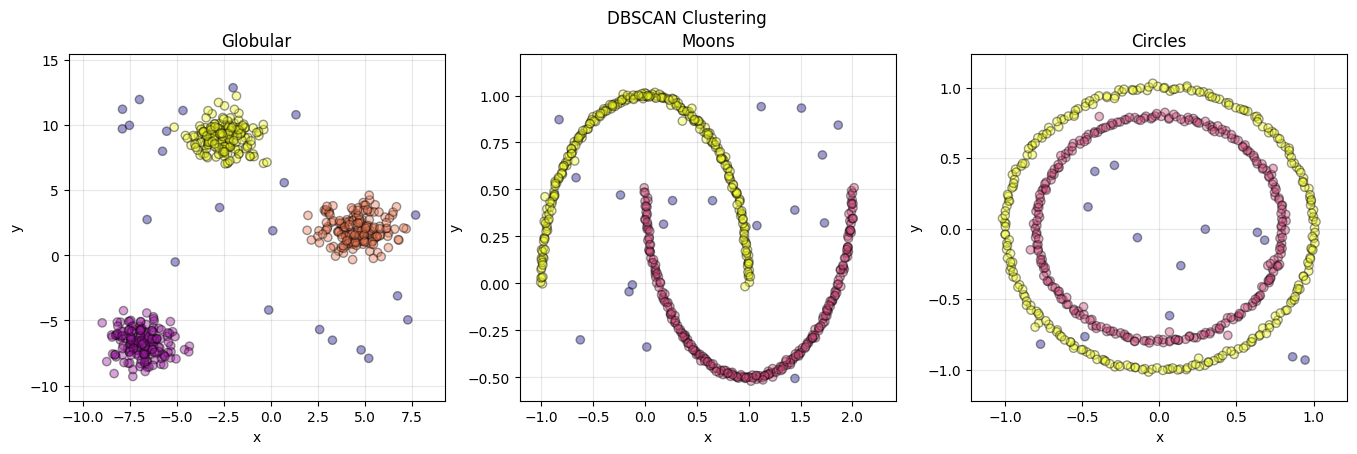

In [285]:
#plot
plot_dfs(
    dfs = [X_blobs, X_moons, X_circles],
    title = "DBSCAN Clustering",
    labels=[dbscan_b_labels, dbscan_m_labels, dbscan_c_labels])

In [286]:
#remove noise from the dataset
noise_label = -1

#blobs
mask = dbscan_b_labels != noise_label
X_blobs_masked = X_blobs[mask]
dbscan_b_labels_masked = dbscan_b_labels[mask]

#moons
mask = dbscan_m_labels != noise_label
X_moons_masked = X_moons[mask]
dbscan_m_labels_masked = dbscan_m_labels[mask]

#circles
mask = dbscan_c_labels != noise_label
X_circles_masked = X_circles[mask]
dbscan_c_labels_masked = dbscan_c_labels[mask]

In [287]:
dbscan_metrics.evaluate_model(f"blobs: e:{str(eps_b)}, ms:{str(min_samples_b)}, nn", X_blobs_masked , dbscan_b_labels_masked)
dbscan_metrics.evaluate_model(f"moons: e:{str(eps_m)}, ms:{str(min_samples_m)}, nn", X_moons_masked, dbscan_m_labels_masked)
dbscan_metrics.evaluate_model(f"circles: e:{str(eps_c)}, ms: {str(min_samples_c)}, nn", X_circles_masked, dbscan_c_labels_masked)

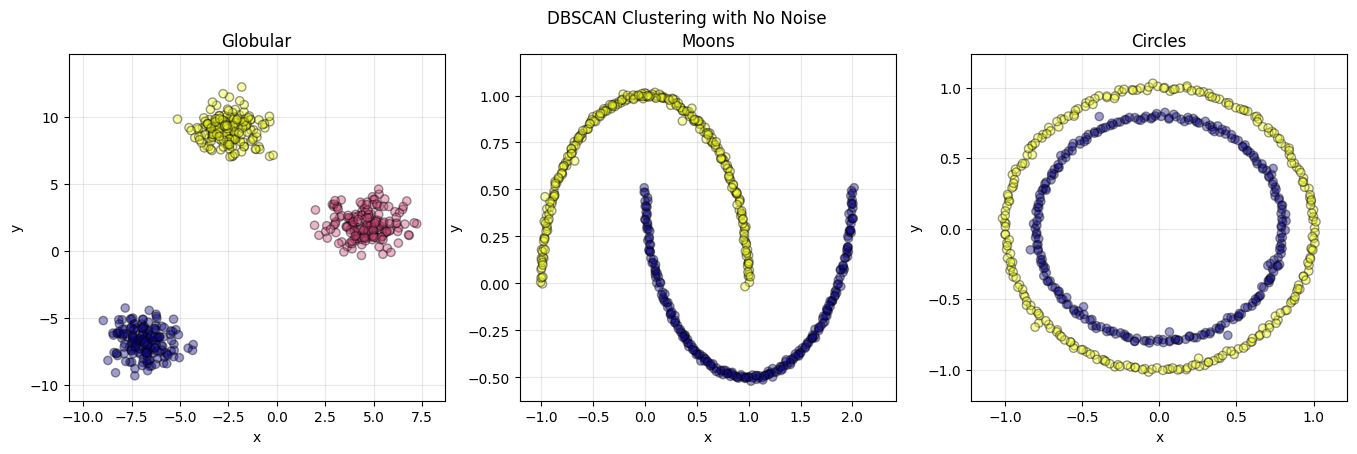

In [288]:
#plot
plot_dfs(
    dfs = [X_blobs_masked, X_moons_masked, X_circles_masked],
    title = "DBSCAN Clustering with No Noise",
    labels=[dbscan_b_labels_masked, dbscan_m_labels_masked, dbscan_c_labels_masked])

In [289]:
dbscan_metrics.print_metrics()

Name: blobs: e:1, ms:8
silhouette: 0.78083
davies_bouldin: 1.42393
calinski_harabasz: 2123.03574

Name: moons: e:0.07, ms:6
silhouette: 0.32964
davies_bouldin: 2.27645
calinski_harabasz: 260.2288

Name: circles: e:0.09, ms: 6
silhouette: 0.10531
davies_bouldin: 3.67998
calinski_harabasz: 75.90576

Name: blobs: e:1, ms:8, nn
silhouette: 0.84392
davies_bouldin: 0.22147
calinski_harabasz: 8465.96971

Name: moons: e:0.07, ms:6, nn
silhouette: 0.33637
davies_bouldin: 1.15141
calinski_harabasz: 337.82755

Name: circles: e:0.09, ms: 6, nn
silhouette: 0.02059
davies_bouldin: 284.0395
calinski_harabasz: 0.00626



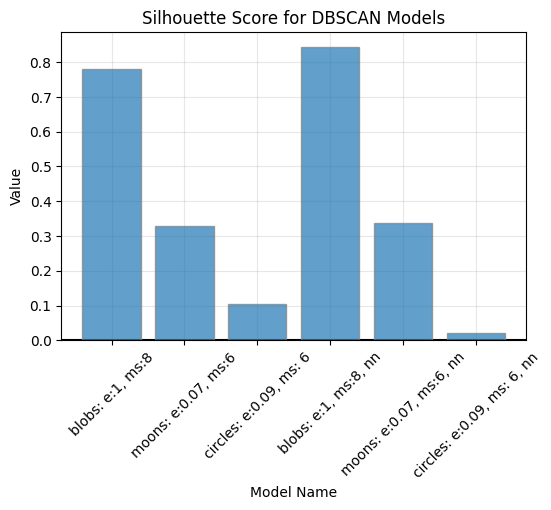

In [290]:
figsize = (6, 4)

dbscan_metrics.plot_models_score("silhouette", title = "Silhouette Score for DBSCAN Models", figsize = figsize, rotation = 45)

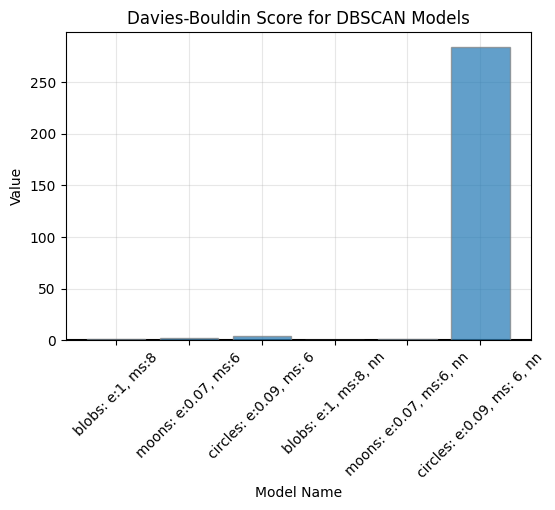

In [291]:
dbscan_metrics.plot_models_score("davies_bouldin", title = "Davies-Bouldin Score for DBSCAN Models", figsize = figsize, rotation = 45)

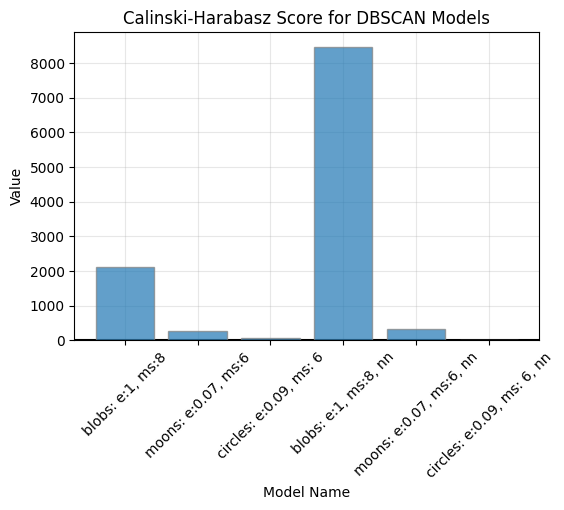

In [292]:
dbscan_metrics.plot_models_score("calinski_harabasz", title = "Calinski-Harabasz Score for DBSCAN Models", figsize = figsize, rotation = 45)

# Model Comperison

In [293]:
metric_objects = [kmeans_metrics, hierarch_metrics, dbscan_metrics]
metric_names = ["silhouette", "davies_bouldin", "calinski_harabasz"]
dataset_types = ["blobs", "moons", "circles"]

In [294]:
#each metrics contains dictionary of sorted list for each dataset type
#each list consist of a tuple - name of the model and the score value
metrics_dict = {metric: {} for metric in metric_names}

for metric_name in metric_names:
  for dataset_type in dataset_types:
    temp_list = [model.get_single_type_metric(dataset_type, metric_name) for model in metric_objects]
    temp_list = list(chain(*temp_list))
    metrics_dict[metric_name][dataset_type] = sorted(temp_list, key=lambda x: x[1])

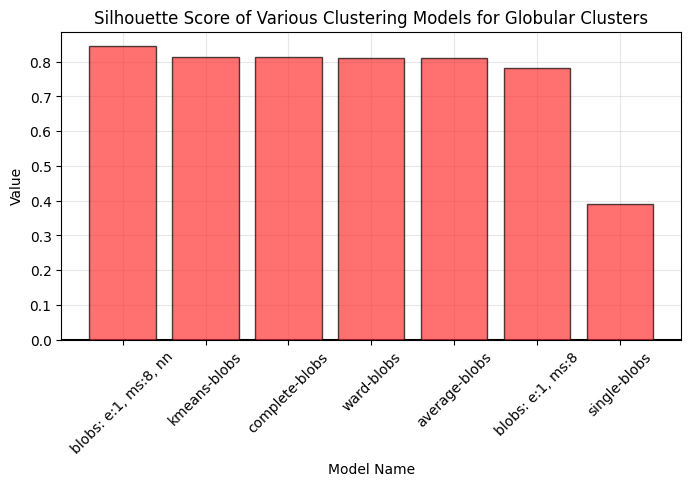

In [295]:
temp_list = metrics_dict['silhouette']['blobs'][::-1]
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Silhouette Score of Various Clustering Models for Globular Clusters")

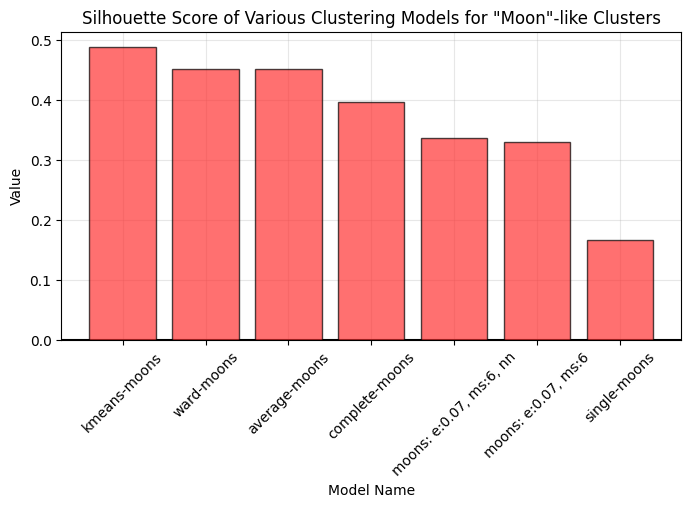

In [296]:
temp_list = metrics_dict['silhouette']['moons'][::-1]
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Silhouette Score of Various Clustering Models for \"Moon\"-like Clusters")

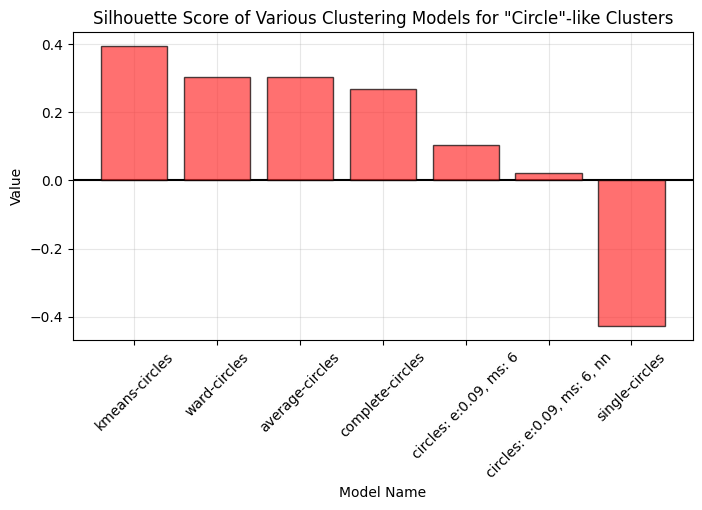

In [297]:
temp_list = metrics_dict['silhouette']['circles'][::-1]
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Silhouette Score of Various Clustering Models for \"Circle\"-like Clusters")

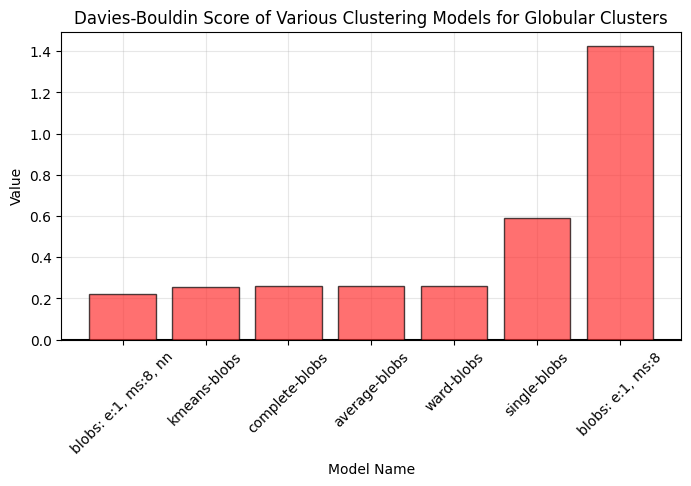

In [298]:
temp_list = metrics_dict['davies_bouldin']['blobs']
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Davies-Bouldin Score of Various Clustering Models for Globular Clusters")

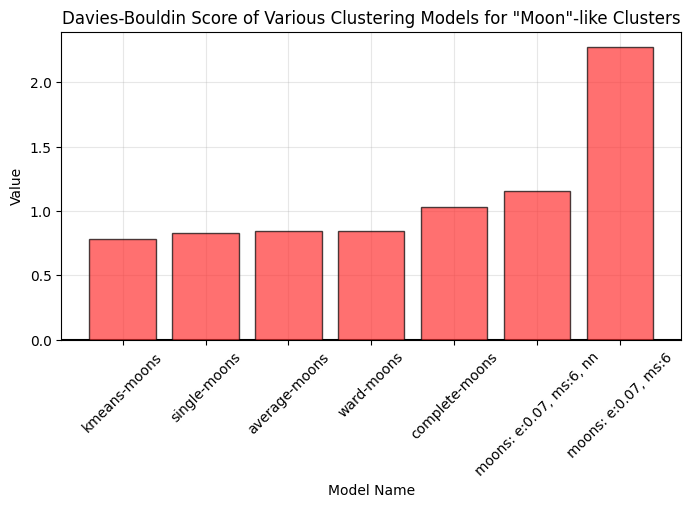

In [299]:
temp_list = metrics_dict['davies_bouldin']['moons']
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Davies-Bouldin Score of Various Clustering Models for \"Moon\"-like Clusters")

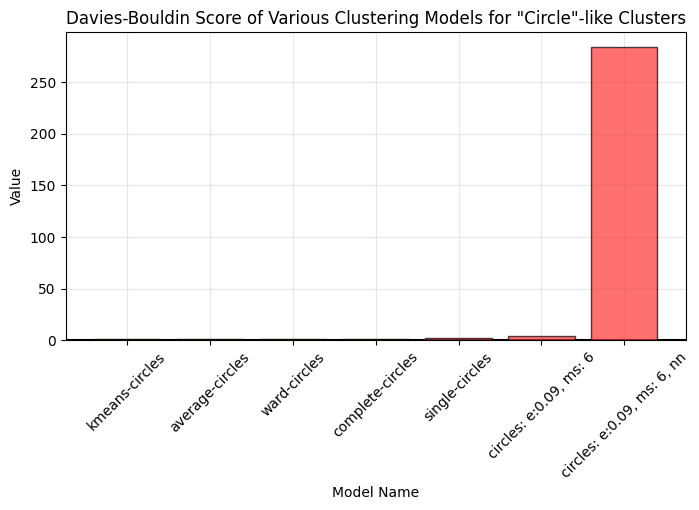

In [300]:
temp_list = metrics_dict['davies_bouldin']['circles']
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Davies-Bouldin Score of Various Clustering Models for \"Circle\"-like Clusters")

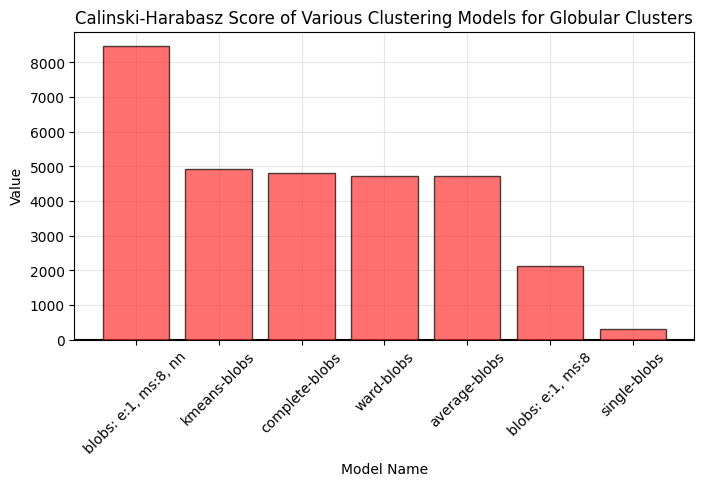

In [301]:
temp_list = metrics_dict['calinski_harabasz']['blobs'][::-1]
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Calinski-Harabasz Score of Various Clustering Models for Globular Clusters")

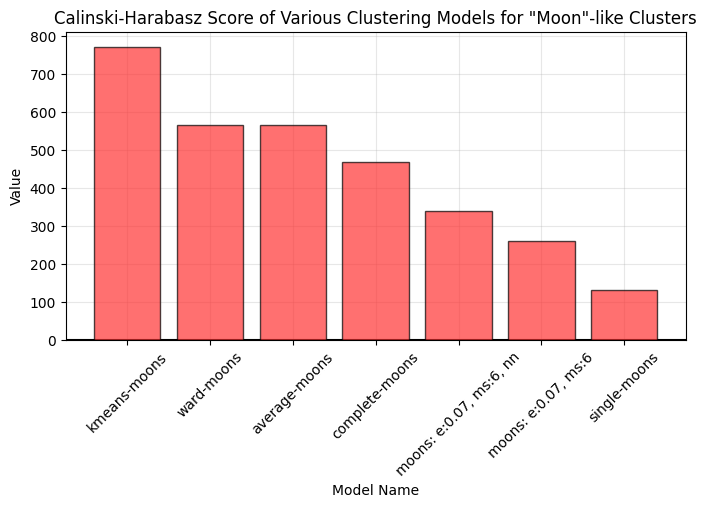

In [302]:
temp_list = metrics_dict['calinski_harabasz']['moons'][::-1]
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Calinski-Harabasz Score of Various Clustering Models for \"Moon\"-like Clusters")

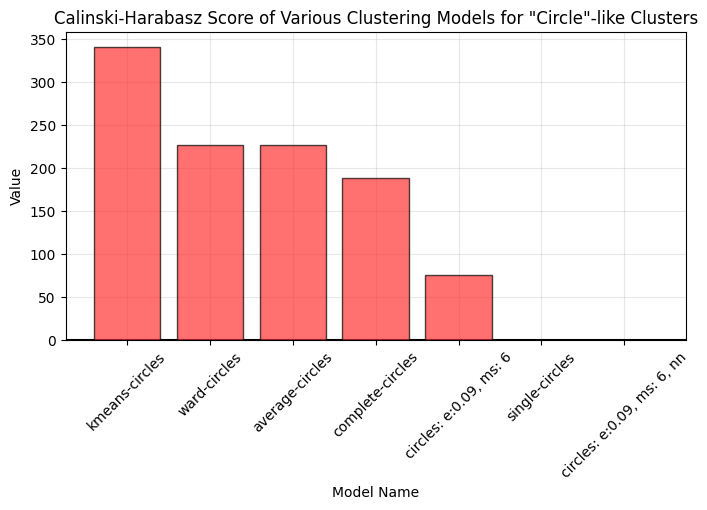

In [303]:
temp_list = metrics_dict['calinski_harabasz']['circles'][::-1]
x, h = zip(*temp_list)

plot_single_metric(x, h, title = "Calinski-Harabasz Score of Various Clustering Models for \"Circle\"-like Clusters")